In [41]:
## UofT SCS FinTech Bootcamp Project 1 Team Code
## Project team: Ambreen Simon, George Barbuc, Katie Gouinlock, Keiran Gugula
# Import libraries required for analysis and visualization
from pathlib import Path
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import datetime as dt
import yfinance as yf
import random
from MCForecastTools import MCSimulation
import hvplot.pandas

%matplotlib inline

In [2]:
# Create dataframe with S&P 500 tickers based on information in CSV file
sp_csv = pd.read_csv(Path("sp500.csv"))

In [3]:
# Keiran can you confirm what this step does ?
tickers = [x for x in sp_csv.loc[:, "Symbol"]]

# Appending SPY ticker to S&P 500 consitutents. SPY will be used as a proxy for S&P 500 returns
tickers.append("SPY")

# Downloading historical price data for S&P 500 securities using Yfinance library
data = yf.download(tickers=tickers, start="2012-01-01", end="2017-01-01", group_by="ticker")

[*********************100%***********************]  506 of 506 completed

12 Failed downloads:
- VIAC: Data doesn't exist for startDate = 1325394000, endDate = 1483246800
- BRK.B: No data found, symbol may be delisted
- FOX: Data doesn't exist for startDate = 1325394000, endDate = 1483246800
- CARR: Data doesn't exist for startDate = 1325394000, endDate = 1483246800
- NLOK: No data found for this date range, symbol may be delisted
- FOXA: Data doesn't exist for startDate = 1325394000, endDate = 1483246800
- OTIS: Data doesn't exist for startDate = 1325394000, endDate = 1483246800
- BF.B: No data found for this date range, symbol may be delisted
- CTVA: Data doesn't exist for startDate = 1325394000, endDate = 1483246800
- IR: Data doesn't exist for startDate = 1325394000, endDate = 1483246800
- HWM: No data found for this date range, symbol may be delisted
- DOW: Data doesn't exist for startDate = 1325394000, endDate = 1483246800


In [4]:
data.head()

SYF                                        AXP             \
           Open High Low Close Adj Close Volume       Open       High   
Date                                                                    
2012-01-03  NaN  NaN NaN   NaN       NaN    NaN  48.299999  48.959999   
2012-01-04  NaN  NaN NaN   NaN       NaN    NaN  48.020000  48.380001   
2012-01-05  NaN  NaN NaN   NaN       NaN    NaN  47.840000  49.250000   
2012-01-06  NaN  NaN NaN   NaN       NaN    NaN  48.869999  48.970001   
2012-01-09  NaN  NaN NaN   NaN       NaN    NaN  48.320000  48.700001   

                                  ...        DPZ                        \
                  Low      Close  ...        Low      Close  Adj Close   
Date                              ...                                    
2012-01-03  48.139999  48.389999  ...  33.090000  33.150002  28.242994   
2012-01-04  47.400002  48.240002  ...  33.099998  33.820000  28.813814   
2012-01-05  47.700001  48.799999  ...  33.029999  33.369999  28.430439   
2012-01-06  48.049999  48.270000  ...  33.130001  33.299999  28.370794   
2012-01-09  48.119999  48.389999  ...  33.330002  33.570000  28.600832   

                             TT                                              \
              Volume       Open       High        Low      Close  Adj Close   
Date                                                                          
2012-01-03  797200.0  19.357700  19.989738  19.357700  19.890596  16.972301   
2012-01-04  450500.0  19.803844  20.026917  19.599363  19.741880  16.845406   
2012-01-05  623500.0  19.679916  20.070293  19.450647  19.964952  17.035748   
2012-01-06  724400.0  20.070293  20.181829  19.816238  19.841024  16.930002   
2012-01-09  566200.0  19.915380  20.200418  19.661327  20.107471  17.157354   

                       
               Volume  
Date                   
2012-01-03  5200200.0  
2012-01-04  3785100.0  
2012-01-05  4396700.0  
2012-01-06  3901600.0  
2012-01-09  3191500.0  

[5 rows x 3036 columns]

In [5]:
# Creating function in order to clean data downloaded from yfinance library
# Cleaning data requires dropping all columns other than close price, and then returning the resulting data frame
def clean_yahoo_df(data):
    data.drop(["Open", "High", "Low", "Adj Close", "Volume"], axis=1, level=1, inplace=True)
    df_clean = data.droplevel(axis=1, level=1)
    return df_clean
    
sp_df_clean = clean_yahoo_df(data)
sp_df_clean.head()

,SYF,AXP,DTE,AJG,UPS,EXPE,LKQ,AAL,MNST,FMC,...,SYK,AZO,IEX,ALXN,MAR,IVZ,SLG,NBL,DPZ,TT
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,NaN,48.389999,53.869999,33.290001,74.160004,29.660000,15.390,5.12,15.416667,37.961838,...,51.070000,319.790009,37.299999,70.570000,30.000000,20.559999,68.160004,48.880001,33.150002,19.890596
2012-01-04,NaN,48.240002,53.599998,32.759998,73.839996,29.030001,15.480,5.03,15.431666,37.888119,...,51.250000,326.959991,37.410000,70.290001,30.469999,20.350000,68.190002,49.290001,33.820000,19.741880
2012-01-05,NaN,48.799999,53.990002,32.840000,73.120003,28.770000,15.800,5.47,15.643333,37.705986,...,51.189999,333.850006,38.090000,72.410004,31.469999,20.570000,69.440002,48.750000,33.369999,19.964952
2012-01-06,NaN,48.270000,53.520000,32.910000,73.480003,29.250000,15.615,5.60,15.896667,38.148308,...,51.500000,338.040009,38.000000,74.449997,31.740000,20.770000,69.779999,48.360001,33.299999,19.841024
2012-01-09,NaN,48.389999,53.520000,32.959999,73.449997,28.629999,15.655,5.72,15.986667,38.148308,...,51.799999,339.500000,38.090000,74.269997,32.169998,20.889999,69.529999,49.165001,33.570000,20.107471


In [6]:
# Storing cleaned data from yfinance to a new dataframe
sp_df_clean.to_csv("sp500_raw_data.csv")

In [2]:
# Creating a new dataframe from the cleaned yfinance S&P 500 data, setting index as the date
sp_path = Path("sp500_raw_data.csv")
sp_combined_df = pd.read_csv(sp_path, index_col='Date',infer_datetime_format=True,parse_dates=True)
sp_combined_df.head(5)

,DIS,ETN,NLOK,EMR,DXCM,AES,DRI,TXT,DGX,NUE,...,ADP,DHR,LLY,FLS,ZION,SBUX,UHS,BF.B,KO,MMM
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,38.310001,45.490002,15.78,47.720001,9.44,12.12,39.912636,18.639999,57.790001,40.520000,...,47.813873,36.732372,41.799999,33.976665,16.770000,22.645000,37.709999,NaN,35.070000,83.489998
2012-01-04,38.849998,45.480000,15.75,48.029999,9.20,12.03,40.189743,19.010000,57.650002,40.880001,...,47.761192,36.664139,40.709999,34.873333,17.139999,23.084999,37.009998,NaN,34.849998,84.180000
2012-01-05,39.500000,45.660000,15.80,47.720001,8.92,12.32,40.618816,19.110001,57.480000,40.950001,...,48.112381,36.838512,40.299999,34.419998,17.620001,23.180000,38.060001,NaN,34.685001,83.800003
2012-01-06,39.910000,45.290001,15.78,47.150002,8.83,12.23,39.635525,19.120001,58.009998,41.169998,...,48.182617,36.641396,39.880001,34.163334,17.639999,23.360001,39.200001,NaN,34.465000,83.370003
2012-01-09,39.750000,45.540001,15.67,47.889999,8.84,12.47,39.349480,19.070000,58.029999,41.080002,...,47.998245,36.830933,39.810001,34.556667,17.879999,23.295000,39.040001,NaN,34.465000,83.870003


In [3]:
## Commencing data cleaning procedures
# Check to confirm whether there are any duplicates in the index variable
sp_combined_df.duplicated()

Date
2012-01-03    False
2012-01-04    False
2012-01-05    False
2012-01-06    False
2012-01-09    False
              ...  
2016-12-23    False
2016-12-27    False
2016-12-28    False
2016-12-29    False
2016-12-30    False
Length: 1260, dtype: bool

In [4]:
# Writing data to a csv file for future use
sp_combined_df.to_csv("sp500_clean.csv")

In [5]:
# Reading in data from csv file and continuing cleaning procedures, beginning first with visualizing data
sp_csv_clean = pd.read_csv(Path("sp500_clean.csv"),index_col='Date',infer_datetime_format=True,parse_dates=True)
sp_csv_clean.head()

,DIS,ETN,NLOK,EMR,DXCM,AES,DRI,TXT,DGX,NUE,...,ADP,DHR,LLY,FLS,ZION,SBUX,UHS,BF.B,KO,MMM
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,38.310001,45.490002,15.78,47.720001,9.44,12.12,39.912636,18.639999,57.790001,40.520000,...,47.813873,36.732372,41.799999,33.976665,16.770000,22.645000,37.709999,NaN,35.070000,83.489998
2012-01-04,38.849998,45.480000,15.75,48.029999,9.20,12.03,40.189743,19.010000,57.650002,40.880001,...,47.761192,36.664139,40.709999,34.873333,17.139999,23.084999,37.009998,NaN,34.849998,84.180000
2012-01-05,39.500000,45.660000,15.80,47.720001,8.92,12.32,40.618816,19.110001,57.480000,40.950001,...,48.112381,36.838512,40.299999,34.419998,17.620001,23.180000,38.060001,NaN,34.685001,83.800003
2012-01-06,39.910000,45.290001,15.78,47.150002,8.83,12.23,39.635525,19.120001,58.009998,41.169998,...,48.182617,36.641396,39.880001,34.163334,17.639999,23.360001,39.200001,NaN,34.465000,83.370003
2012-01-09,39.750000,45.540001,15.67,47.889999,8.84,12.47,39.349480,19.070000,58.029999,41.080002,...,47.998245,36.830933,39.810001,34.556667,17.879999,23.295000,39.040001,NaN,34.465000,83.870003


In [6]:
# Confirming number of entries in data frame
sp_csv_clean.shape

(1260, 506)

In [7]:
# Checking for null values
sp_csv_clean.isnull().sum()

DIS        2
ETN        2
NLOK       2
EMR        2
DXCM       2
        ... 
SBUX       2
UHS        2
BF.B    1260
KO         2
MMM        2
Length: 506, dtype: int64

In [8]:
# Further exploring data frame in preparation for cleaning of data
sp_csv_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1260 entries, 2012-01-03 to 2016-12-30
Columns: 506 entries, DIS to MMM
dtypes: float64(506)
memory usage: 4.9 MB


In [9]:
# Confirming data types in dataframe are all float values
sp_csv_clean.dtypes

DIS     float64
ETN     float64
NLOK    float64
EMR     float64
DXCM    float64
         ...   
SBUX    float64
UHS     float64
BF.B    float64
KO      float64
MMM     float64
Length: 506, dtype: object

In [10]:
# Confirming maximum amount of data, i.e. number of trading days
# that will be included in the period is 1258
sp_csv_clean.count()

DIS     1258
ETN     1258
NLOK    1258
EMR     1258
DXCM    1258
        ... 
SBUX    1258
UHS     1258
BF.B       0
KO      1258
MMM     1258
Length: 506, dtype: int64

In [11]:
# Checking for null values in data set (anticipate there will be some)
# with stocks that were not present in the S&P 500 for the full time, as well as 2 days of blank trading data previously identified

sp_csv_clean.isnull()

,DIS,ETN,NLOK,EMR,DXCM,AES,DRI,TXT,DGX,NUE,...,ADP,DHR,LLY,FLS,ZION,SBUX,UHS,BF.B,KO,MMM
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2012-01-04,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2012-01-05,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2012-01-06,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2012-01-09,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2016-12-27,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2016-12-28,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [12]:
#Checking for nulls
sp_csv_clean.isnull().mean() *100

DIS       0.15873
ETN       0.15873
NLOK      0.15873
EMR       0.15873
DXCM      0.15873
          ...    
SBUX      0.15873
UHS       0.15873
BF.B    100.00000
KO        0.15873
MMM       0.15873
Length: 506, dtype: float64

In [13]:
# Dropping all rows with morethan two null values, threshold prevents us from dropping entire data set as a result of two trading days of missning data
df_all_no_null=sp_csv_clean.dropna(thresh=2).copy()

In [14]:
# Drop those tickers that do not have complete price history for the 2012 to 2017 time fram in scope for analysis
df_all_clean = df_all_no_null.dropna(axis=1)
df_all_clean.head()

,DIS,ETN,NLOK,EMR,DXCM,AES,DRI,TXT,DGX,NUE,...,KR,ADP,DHR,LLY,FLS,ZION,SBUX,UHS,KO,MMM
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,38.310001,45.490002,15.78,47.720001,9.44,12.12,39.912636,18.639999,57.790001,40.520000,...,12.260,47.813873,36.732372,41.799999,33.976665,16.770000,22.645000,37.709999,35.070000,83.489998
2012-01-04,38.849998,45.480000,15.75,48.029999,9.20,12.03,40.189743,19.010000,57.650002,40.880001,...,12.135,47.761192,36.664139,40.709999,34.873333,17.139999,23.084999,37.009998,34.849998,84.180000
2012-01-05,39.500000,45.660000,15.80,47.720001,8.92,12.32,40.618816,19.110001,57.480000,40.950001,...,12.145,48.112381,36.838512,40.299999,34.419998,17.620001,23.180000,38.060001,34.685001,83.800003
2012-01-06,39.910000,45.290001,15.78,47.150002,8.83,12.23,39.635525,19.120001,58.009998,41.169998,...,12.095,48.182617,36.641396,39.880001,34.163334,17.639999,23.360001,39.200001,34.465000,83.370003
2012-01-09,39.750000,45.540001,15.67,47.889999,8.84,12.47,39.349480,19.070000,58.029999,41.080002,...,12.130,47.998245,36.830933,39.810001,34.556667,17.879999,23.295000,39.040001,34.465000,83.870003


In [15]:
# Confirm cleanse of data worked by re-running check for null values
df_all_no_null.isnull().sum()

DIS        0
ETN        0
NLOK       0
EMR        0
DXCM       0
        ... 
SBUX       0
UHS        0
BF.B    1258
KO         0
MMM        0
Length: 506, dtype: int64

In [16]:
df_all_no_null.head()

,DIS,ETN,NLOK,EMR,DXCM,AES,DRI,TXT,DGX,NUE,...,ADP,DHR,LLY,FLS,ZION,SBUX,UHS,BF.B,KO,MMM
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,38.310001,45.490002,15.78,47.720001,9.44,12.12,39.912636,18.639999,57.790001,40.520000,...,47.813873,36.732372,41.799999,33.976665,16.770000,22.645000,37.709999,NaN,35.070000,83.489998
2012-01-04,38.849998,45.480000,15.75,48.029999,9.20,12.03,40.189743,19.010000,57.650002,40.880001,...,47.761192,36.664139,40.709999,34.873333,17.139999,23.084999,37.009998,NaN,34.849998,84.180000
2012-01-05,39.500000,45.660000,15.80,47.720001,8.92,12.32,40.618816,19.110001,57.480000,40.950001,...,48.112381,36.838512,40.299999,34.419998,17.620001,23.180000,38.060001,NaN,34.685001,83.800003
2012-01-06,39.910000,45.290001,15.78,47.150002,8.83,12.23,39.635525,19.120001,58.009998,41.169998,...,48.182617,36.641396,39.880001,34.163334,17.639999,23.360001,39.200001,NaN,34.465000,83.370003
2012-01-09,39.750000,45.540001,15.67,47.889999,8.84,12.47,39.349480,19.070000,58.029999,41.080002,...,47.998245,36.830933,39.810001,34.556667,17.879999,23.295000,39.040001,NaN,34.465000,83.870003


In [17]:
# Save cleaned data to a new csv for further analysis
df_all_clean.to_csv("final_clean_df.csv")

In [18]:
# Create new dataframe with daily returns based on S&P 500 price data
daily_returns = df_all_clean.pct_change()

# Drop first row which is null following conversion to returns
daily_returns.dropna().copy()
daily_returns.head()

,DIS,ETN,NLOK,EMR,DXCM,AES,DRI,TXT,DGX,NUE,...,KR,ADP,DHR,LLY,FLS,ZION,SBUX,UHS,KO,MMM
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-04,0.014095,-0.000220,-0.001901,0.006496,-0.025424,-0.007426,0.006943,0.019850,-0.002423,0.008885,...,-0.010196,-0.001102,-0.001858,-0.026077,0.026391,0.022063,0.019430,-0.018563,-0.006273,0.008264
2012-01-05,0.016731,0.003958,0.003175,-0.006454,-0.030435,0.024106,0.010676,0.005260,-0.002949,0.001712,...,0.000824,0.007353,0.004756,-0.010071,-0.012999,0.028005,0.004115,0.028371,-0.004734,-0.004514
2012-01-06,0.010380,-0.008103,-0.001266,-0.011945,-0.010090,-0.007305,-0.024208,0.000523,0.009221,0.005372,...,-0.004117,0.001460,-0.005351,-0.010422,-0.007457,0.001135,0.007765,0.029953,-0.006343,-0.005131
2012-01-09,-0.004009,0.005520,-0.006971,0.015695,0.001133,0.019624,-0.007217,-0.002615,0.000345,-0.002186,...,0.002894,-0.003827,0.005173,-0.001755,0.011513,0.013605,-0.002783,-0.004082,0.000000,0.005997


In [19]:
# Create function find_beta to calculate beta for each ticker and store the result in a dictionary

def find_beta(df):

    index_returns = df.iloc[:,0]
    df_beta = {}
    
    for ticker in df:
        covariance = df[ticker].cov(index_returns)
        variance = df[ticker].var()
        beta = covariance/variance
        df_beta[ticker] = beta
    
    return df_beta



In [20]:
# Calculate and store betas in a dictionary for each ticker in the daily returns data (S&P 500 + SPY)
beta = find_beta(daily_returns)


In [21]:
# Create df with beta values, sort in descending order, and print output to validate calculations
beta_df = pd.DataFrame.from_dict(beta, orient="index")
beta_df = beta_df.rename(columns={0: "Beta"})
beta_df = beta_df.sort_values(["Beta"],ascending=False)
beta_df.tail()

,Beta
VRTX,0.084184
AMD,0.082526
ABMD,0.071854
NFLX,0.056312
NEM,0.005846


In [22]:
# Start construction of high and low vol portfolios, by transposting daily returns data and sorting by t
daily_returns_transposed = df_all_clean.transpose()
daily_returns_transposed.sort_index(ascending=True)

Date,2012-01-03,2012-01-04,2012-01-05,2012-01-06,2012-01-09,2012-01-10,2012-01-11,2012-01-12,2012-01-13,2012-01-17,...,2016-12-16,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-27,2016-12-28,2016-12-29,2016-12-30
A,26.094421,25.886982,26.466381,26.752504,27.453505,27.968527,27.839771,28.268955,27.939915,28.605150,...,45.910000,45.430000,46.209999,46.040001,45.970001,46.200001,46.509998,45.720001,45.639999,45.560001
AAL,5.120000,5.030000,5.470000,5.600000,5.720000,5.720000,5.910000,6.050000,5.970000,5.880000,...,47.630001,48.580002,49.220001,49.470001,48.689999,48.480000,48.610001,47.669998,47.250000,46.689999
AAP,69.099998,70.720001,71.169998,71.500000,71.480003,71.540001,72.019997,71.650002,71.459999,72.080002,...,171.910004,173.820007,175.630005,173.509995,170.389999,170.889999,171.839996,170.419998,170.279999,169.119995
AAPL,14.686786,14.765715,14.929643,15.085714,15.061786,15.115714,15.091071,15.049643,14.993215,15.167857,...,28.992500,29.160000,29.237499,29.264999,29.072500,29.129999,29.315001,29.190001,29.182501,28.955000
ABC,38.070000,38.200001,38.490002,38.590000,38.570000,39.009998,38.610001,38.840000,37.799999,38.299999,...,77.379997,78.419998,79.300003,78.849998,77.809998,78.559998,78.820000,78.349998,79.339996,78.190002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYL,25.139999,25.969999,25.600000,25.170000,25.270000,25.580000,26.059999,25.700001,25.629999,25.629999,...,50.099998,50.759998,50.919998,50.830002,51.130001,51.009998,50.860001,49.939999,49.770000,49.520000
YUM,42.106400,42.393963,42.717468,43.026600,42.861252,43.127247,43.795830,43.752697,44.018692,44.493172,...,64.250000,64.040001,64.220001,64.190002,64.050003,63.810001,64.029999,63.720001,63.630001,63.330002
ZBH,53.939999,53.209999,53.840000,53.980000,54.380001,55.520000,55.299999,55.060001,55.040001,55.189999,...,103.500000,102.860001,101.849998,101.660004,101.570000,102.320000,103.139999,103.059998,103.500000,103.199997
ZBRA,35.720001,35.450001,35.400002,35.110001,34.950001,35.270000,35.590000,34.990002,34.970001,35.549999,...,84.519997,86.279999,87.489998,86.769997,86.169998,86.419998,87.050003,85.610001,85.940002,85.760002


In [23]:
# Confirm shape including # of rows (and therefore unique tickers) in daily returns dataframe
daily_returns_transposed.shape

(465, 1258)

In [24]:
# Sort dataframe by ticker and confirm # of rows (and therefore unique tickers)
beta_df = beta_df.sort_index(ascending=True)
beta_df.head()

,Beta
A,0.341602
AAL,0.139104
AAP,0.199245
AAPL,0.209772
ABC,0.278930


In [25]:
# Merge beta information with daily returns in order to assign a calculated beta to each of the stock tickers in the dataset
df_returns_w_beta = pd.concat([beta_df, daily_returns_transposed], join="inner", axis=1)
# Sort values from low to high beta in preparation for creating low and high beta portfolios
df_returns_w_beta = df_returns_w_beta.sort_values(["Beta"])
df_returns_w_beta.head()

,Beta,2012-01-03 00:00:00,2012-01-04 00:00:00,2012-01-05 00:00:00,2012-01-06 00:00:00,2012-01-09 00:00:00,2012-01-10 00:00:00,2012-01-11 00:00:00,2012-01-12 00:00:00,2012-01-13 00:00:00,...,2016-12-16 00:00:00,2016-12-19 00:00:00,2016-12-20 00:00:00,2016-12-21 00:00:00,2016-12-22 00:00:00,2016-12-23 00:00:00,2016-12-27 00:00:00,2016-12-28 00:00:00,2016-12-29 00:00:00,2016-12-30 00:00:00
NEM,0.005846,62.080002,61.889999,62.099998,61.970001,61.480000,62.650002,63.340000,64.040001,63.389999,...,31.660000,31.780001,31.660000,31.549999,31.440001,32.459999,32.590000,32.779999,35.270000,34.070000
NFLX,0.056312,10.320000,11.492857,11.328571,12.327143,14.025714,13.690000,13.164286,13.164286,13.482857,...,124.220001,125.449997,125.120003,126.500000,125.580002,125.589996,128.350006,125.889999,125.330002,123.800003
ABMD,0.071854,18.250000,18.110001,18.270000,18.139999,18.209999,18.160000,18.240000,18.320000,17.980000,...,117.540001,116.769997,113.099998,113.559998,111.550003,112.379997,113.739998,112.779999,113.580002,112.680000
AMD,0.082526,5.480000,5.460000,5.460000,5.430000,5.590000,5.710000,5.810000,5.820000,5.660000,...,10.660000,10.950000,11.510000,11.470000,11.600000,11.580000,12.070000,11.550000,11.590000,11.340000
VRTX,0.084184,32.230000,32.200001,33.119999,34.049999,35.680000,36.320000,37.320000,37.070000,36.810001,...,76.800003,76.300003,76.440002,72.599998,72.019997,74.309998,75.190002,74.589996,74.440002,73.669998


In [26]:
# Creating two portfolios, one with stocks with the highest 50 betas, the other with the lowest 50 betas
low_vol_port = df_returns_w_beta.head(50)
high_vol_port = df_returns_w_beta.tail(50)

In [27]:
# Once portfolio has been selected, drop beta value, as it is no longer required in order to perform portfolio analysis
low_vol_no_beta = low_vol_port.drop(columns=["Beta"])
high_vol_no_beta = high_vol_port.drop(columns=["Beta"])

In [28]:
# Re-orienting portfolio dataframes in order to have data as a column and tickers as rows
low_vol = low_vol_no_beta.transpose()
high_vol = high_vol_no_beta.transpose()

In [29]:
# Dropping first row of null values (Jan 3 data) to create final high and low beta porfolios
low_vol.dropna(inplace=True)
high_vol.dropna(inplace=True)

In [30]:
# Creating a portfolio with just "SPY US EQUITY" which will function as a proxy for the S&P 500 index return
index_port = df_all_clean["SPY"].to_frame()
#index_port.dropna(inplace=True)
index_port.head()

,SPY
Date,
2012-01-03,127.500000
2012-01-04,127.699997
2012-01-05,128.039993
2012-01-06,127.709999
2012-01-09,128.020004


In [31]:
# Generating fourth portfolio of randomly chosen symbols
rand_port = df_all_clean.sample(n=50,axis='columns')
rand_port.dropna(inplace=True)

In [32]:
## Running Montecarlo simulation on different portfolios
low_vol_MC=pd.concat([low_vol],axis=1,keys=['close']).swaplevel(0,1,1)
high_vol_MC=pd.concat([high_vol],axis=1,keys=['close']).swaplevel(0,1,1)
rand_port_MC=pd.concat([rand_port],axis=1,keys=['close']).swaplevel(0,1,1)
index_port_MC=pd.concat([index_port],axis=1,keys=['close']).swaplevel(0,1,1)

In [33]:
index_port_MC.head()

,SPY
,close
Date,
2012-01-03,127.500000
2012-01-04,127.699997
2012-01-05,128.039993
2012-01-06,127.709999
2012-01-09,128.020004


In [34]:
# Monte Carlo Simulation
num_sims=500

MC_low_vol = MCSimulation(
    portfolio_data = low_vol_MC,
    num_simulation = num_sims,
    num_trading_days = 252*2
)
MC_low_vol.calc_cumulative_return()


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000448,0.995605,1.004815,1.004154,1.005538,0.996654,0.994597,0.996126,1.006443,1.000871,...,0.995140,1.007720,0.998358,0.995911,1.002249,1.000555,1.003899,1.000629,1.000032,0.999192
2,0.997758,0.993792,1.003995,1.002578,1.006203,0.997243,0.997227,0.992908,1.004409,1.006002,...,0.987856,1.010740,1.002871,1.000313,1.004241,1.011068,1.003087,1.000977,0.993697,0.995181
3,0.995373,0.993278,1.002551,1.006744,1.003156,0.999853,1.004252,0.995904,0.999711,1.004618,...,0.991565,1.005841,0.999529,0.996966,1.007036,1.012926,1.006410,1.003261,0.993858,0.995024
4,0.993733,0.992073,0.997845,1.003965,1.007014,1.002018,1.002858,0.988228,1.001883,1.003414,...,0.989077,1.006485,1.002738,0.996542,1.008781,1.015327,1.006950,1.002474,0.995485,0.998583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,1.693133,1.363611,1.569308,1.505323,1.495831,1.667517,1.438609,1.474201,1.742969,1.381007,...,1.557007,1.817191,1.589750,1.536829,1.841217,1.623645,1.662296,1.502543,1.587950,1.477541
501,1.694550,1.362009,1.570505,1.508915,1.499929,1.666825,1.441855,1.476014,1.745677,1.384414,...,1.555423,1.819508,1.595163,1.539650,1.844969,1.628906,1.672337,1.501741,1.590567,1.478831
502,1.693424,1.367041,1.559742,1.507772,1.503676,1.660180,1.448931,1.477502,1.753475,1.384625,...,1.557526,1.828043,1.595206,1.540191,1.850695,1.636072,1.672004,1.505884,1.584530,1.476746
503,1.696695,1.372609,1.554776,1.508350,1.502392,1.659634,1.449437,1.476528,1.759598,1.386764,...,1.560527,1.829547,1.592545,1.544174,1.866073,1.629851,1.674377,1.503892,1.592962,1.476817


In [35]:
MC_high_vol = MCSimulation(
    portfolio_data = high_vol_MC,
    num_simulation = num_sims,
    num_trading_days = 252*2
)
MC_high_vol.calc_cumulative_return()


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000884,0.998856,1.001331,0.999553,0.999713,1.002987,1.000820,0.999181,1.000651,0.998737,...,1.000596,1.001571,1.000775,1.000949,1.001969,1.000649,1.001428,1.000813,1.000238,1.000494
2,0.998904,0.999743,1.002064,1.000464,0.998692,1.003653,1.002861,1.000506,1.001088,1.000866,...,0.999051,1.004403,1.000021,1.001565,1.002135,1.002890,0.999805,1.001861,0.998815,0.999261
3,0.996846,1.001751,1.004591,1.000639,0.998330,1.003021,1.002983,1.001113,1.001977,1.000882,...,1.000287,1.004159,0.999974,1.001911,1.003499,1.004075,1.001376,1.001154,1.000374,1.000436
4,0.995896,1.004349,1.005418,1.003810,1.001136,1.004020,1.001909,1.000361,1.004297,1.001410,...,1.000372,1.006708,0.998790,1.003607,1.003229,1.005339,1.001367,1.000595,1.001603,1.000513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,1.269683,1.434755,1.369290,1.365647,1.295603,1.307865,1.326097,1.362124,1.306085,1.379672,...,1.355515,1.412551,1.325046,1.372945,1.376085,1.279839,1.346319,1.346644,1.349947,1.365268
501,1.270789,1.434765,1.368612,1.368077,1.297003,1.309239,1.326843,1.362589,1.308292,1.381770,...,1.354395,1.411760,1.327672,1.371340,1.378319,1.281719,1.348067,1.346606,1.353038,1.368026
502,1.273428,1.440179,1.370010,1.366139,1.297871,1.312813,1.328545,1.362901,1.310144,1.382378,...,1.358064,1.412569,1.330526,1.369601,1.379414,1.280555,1.351522,1.350626,1.352695,1.368206
503,1.273072,1.443662,1.370907,1.365795,1.299419,1.314299,1.327435,1.362198,1.312009,1.384134,...,1.361606,1.409375,1.332200,1.370054,1.376704,1.280797,1.353742,1.350390,1.349260,1.369327


In [36]:
MC_rand_port = MCSimulation(
    portfolio_data = rand_port_MC,
    num_simulation = num_sims,
    num_trading_days = 252*2
)
MC_rand_port.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.003693,0.999504,1.000728,0.999391,0.998900,0.997766,0.999789,1.001946,0.997395,1.002789,...,1.000158,1.000838,1.003507,1.000096,0.999457,0.999929,0.999500,0.997640,1.001279,0.998159
2,1.000054,0.999961,1.002236,0.997955,1.001288,0.997539,0.997705,1.006619,0.998532,1.007137,...,0.998496,0.999423,1.000791,0.997671,1.002423,0.999885,1.001486,0.997247,1.004327,0.997229
3,0.997483,0.997583,1.002802,0.997227,1.000573,0.996269,0.997717,1.009224,1.000369,1.004844,...,0.999540,1.001414,0.998527,0.993635,1.002300,1.000495,1.002553,0.996289,1.006336,0.999443
4,0.999997,0.998723,1.004895,0.996789,0.998860,0.994604,1.001784,1.012469,1.003767,1.006119,...,0.998783,0.996528,0.998195,0.990391,1.002387,1.001442,1.000792,0.994507,1.008336,1.000092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,1.456187,1.505230,1.389097,1.380379,1.407756,1.436258,1.438268,1.425583,1.324073,1.378501,...,1.370669,1.329616,1.403911,1.434894,1.390607,1.384585,1.457374,1.373799,1.318761,1.412896
501,1.459781,1.506955,1.390057,1.383277,1.412323,1.437578,1.437997,1.423955,1.324712,1.378327,...,1.370633,1.329880,1.403916,1.433473,1.397413,1.380579,1.457079,1.372565,1.318730,1.414118
502,1.462457,1.514685,1.393028,1.376404,1.415783,1.430485,1.439227,1.424729,1.323303,1.376217,...,1.370378,1.328100,1.401296,1.437666,1.399863,1.378551,1.461601,1.374462,1.316718,1.417971
503,1.465306,1.512473,1.395656,1.378580,1.416848,1.432389,1.439055,1.431012,1.329022,1.376908,...,1.369116,1.332316,1.406314,1.435514,1.399955,1.378642,1.461769,1.375901,1.314932,1.411534


In [37]:
MC_index_port = MCSimulation(
    portfolio_data = index_port_MC,
    num_simulation = num_sims,
    num_trading_days = 252*2
)
MC_index_port.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.003805,1.001530,0.982864,1.001045,1.001747,1.011496,1.002292,1.007189,1.013203,1.006207,...,0.996281,0.994866,1.004803,0.983949,1.010911,0.996916,0.996834,0.995292,0.999280,0.998173
2,0.988812,1.005650,0.989682,0.991263,1.005642,1.026490,1.000567,1.001908,1.012862,1.001729,...,0.992136,1.014348,1.002091,0.981872,0.998893,0.999440,0.995315,0.987041,1.010255,1.011860
3,0.972816,1.011076,0.978542,0.983631,1.006805,1.019154,0.993341,0.987910,1.017572,1.014866,...,0.982996,1.011098,1.006271,0.977585,0.983317,1.006013,0.980812,0.990143,1.031371,1.005740
4,0.958838,1.015550,0.975983,0.992246,0.996457,1.010644,0.986067,0.993827,1.015532,1.007785,...,0.977993,1.006517,1.002273,0.975222,0.977461,1.000456,0.985557,0.986319,1.032152,1.006617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,1.523408,1.203939,1.527244,1.125415,1.132167,1.083205,0.946896,1.314299,1.100406,1.451124,...,1.076883,1.299969,1.237598,1.111542,1.489352,1.092432,1.370319,1.487618,1.250316,1.396857
501,1.515093,1.194709,1.507305,1.119163,1.128541,1.093773,0.943574,1.311334,1.107229,1.451414,...,1.069294,1.288006,1.244959,1.106256,1.498487,1.092084,1.374935,1.484461,1.247976,1.383996
502,1.512435,1.206192,1.503683,1.132108,1.112384,1.092894,0.937867,1.311558,1.100142,1.454416,...,1.071176,1.281722,1.246562,1.116819,1.506930,1.093139,1.397322,1.483917,1.243937,1.383935
503,1.522943,1.197855,1.491697,1.124723,1.118273,1.091977,0.939166,1.316943,1.097663,1.443625,...,1.065641,1.284651,1.238960,1.105580,1.499186,1.069799,1.413473,1.468713,1.251005,1.407196


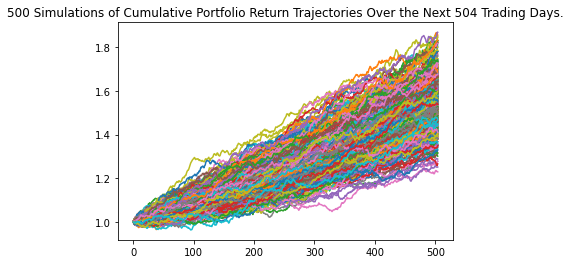

In [38]:
line_plot_low=MC_low_vol.plot_simulation()

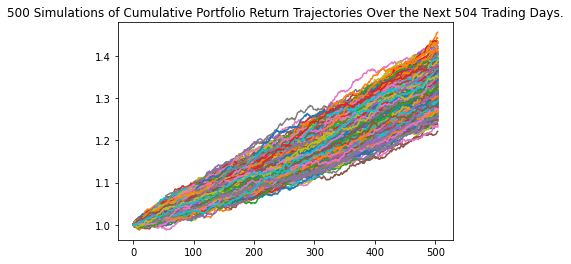

In [39]:
line_plot_high=MC_high_vol.plot_simulation()

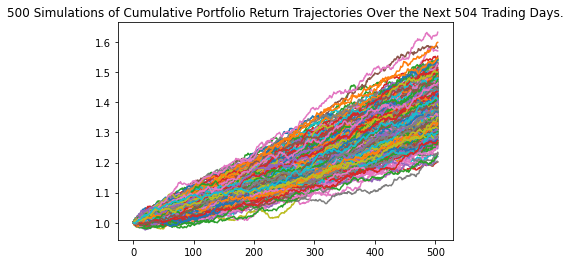

In [40]:
line_plot_rand=MC_rand_port.plot_simulation()

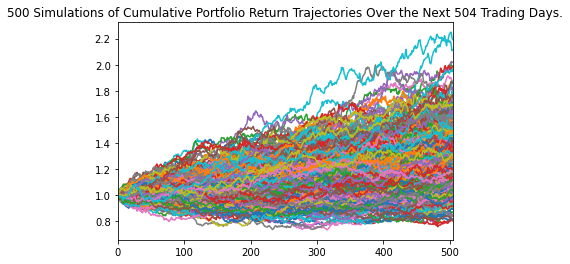

In [118]:
line_plot_index=MC_index_port.plot_simulation()

In [51]:
##Calculating portfolio returns for each option and return on a $10,000 invesment, specifically cumulative returns and the value of a $10,000 investment
#Starting first with low beta portfolio
initial_investment_low = 10000
weights = [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]

low_vol_returns = low_vol.pct_change().dropna()
low_vol_returns.head()

,NEM,NFLX,ABMD,AMD,VRTX,FCX,DXCM,TMUS,INCY,BBY,...,IPGP,EW,ATVI,MYL,HCA,MPC,GPS,REGN,LDOS,NOV
2012-01-04 00:00:00,-0.003061,0.113649,-0.007671,-0.003650,-0.000931,0.008354,-0.025424,-0.063898,-0.014009,-0.019003,...,0.016983,-0.016111,-0.007377,-0.018510,-0.038817,0.010476,0.017790,0.024810,-0.002381,0.000988
2012-01-05 00:00:00,0.003393,-0.014295,0.008835,0.000000,0.028571,-0.013307,-0.030435,-0.088737,0.045332,0.009040,...,0.056777,0.015669,0.000000,-0.011500,0.023558,-0.054502,-0.032309,0.053778,-0.001591,-0.002678
2012-01-06 00:00:00,-0.002093,0.088146,-0.007116,-0.005495,0.028080,-0.010941,-0.010090,0.001248,0.055016,0.033276,...,0.020806,0.012926,0.010735,-0.000931,0.049319,-0.008145,-0.014778,0.079587,-0.010359,0.000848
2012-01-09 00:00:00,-0.007907,0.137791,0.003859,0.029466,0.047871,0.004374,0.001133,0.022444,-0.001227,0.016515,...,0.017028,-0.003430,-0.003268,0.011178,-0.030886,-0.022110,0.003333,-0.004712,0.010467,0.010451
2012-01-10 00:00:00,0.019031,-0.023936,-0.002746,0.021467,0.017937,0.039959,0.002262,0.012195,-0.013514,0.004062,...,0.203196,0.024232,0.020492,0.022110,0.037413,0.028101,0.004430,0.136836,0.032669,0.032704


<AxesSubplot:>

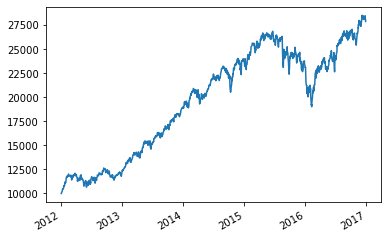

In [53]:
low_vol_combined = low_vol_returns.dot(weights)
low_vol_cumulative = (1 + low_vol_combined).cumprod()
low_vol_profit = initial_investment_low * low_vol_cumulative
low_vol_profit.plot()

In [54]:
#Calculating portfolio metrics for high beta portfolio, specifically cumulative returns and the value of a $10,000 investment
initial_investment_high = 10000
weights = [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]

high_vol_returns = high_vol.pct_change().dropna()
high_vol_returns.head()

,MCD,T,WM,VNO,LMT,GD,ECL,GE,GPC,AON,...,PAYX,CB,JNJ,GL,MMM,AJG,MMC,ADP,SPY,DIS
2012-01-04 00:00:00,0.005565,0.001646,-0.014921,-0.022827,-0.013533,0.001765,0.000862,0.010893,0.000324,-0.016798,...,-0.006572,-0.009526,-0.006072,-0.006630,0.008264,-0.015921,-0.011314,-0.001102,0.001569,0.014095
2012-01-05 00:00:00,0.004427,-0.000986,0.008037,0.013858,-0.010382,-0.010570,0.002411,-0.000539,0.004374,0.005623,...,0.017532,0.002871,-0.001222,0.012198,-0.004514,0.002442,-0.009854,0.007353,0.002662,0.016731
2012-01-06 00:00:00,0.007713,-0.023684,0.011653,0.001562,-0.001124,0.003264,0.001374,0.005391,-0.003548,-0.007742,...,0.000975,0.002433,-0.008716,-0.011824,-0.005131,0.002132,-0.013804,0.001460,-0.002577,0.010380
2012-01-09 00:00:00,-0.009543,-0.000674,-0.001516,0.004159,0.000750,0.011091,0.004460,0.011260,0.004370,0.002601,...,0.011042,0.004569,0.001542,-0.002301,0.005997,0.001519,0.002279,-0.003827,0.002427,-0.004009
2012-01-10 00:00:00,0.000602,0.003372,0.014572,0.016179,0.007246,0.022817,0.005636,-0.007423,0.012248,0.010376,...,-0.000964,0.006397,0.004158,0.012223,0.005127,0.001517,0.007795,-0.000183,0.008671,-0.003019


<AxesSubplot:>

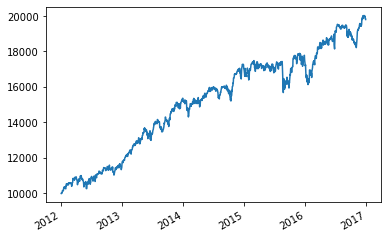

In [55]:
high_vol_combined = high_vol_returns.dot(weights)
high_vol_cumulative = (1 + high_vol_combined).cumprod()
high_vol_profit = initial_investment_high * high_vol_cumulative
high_vol_profit.plot()

In [56]:
#Calculating portfolio metrics for index portfolio (use ETF SPY as a proxy), specifically cumulative returns and the value of a $10,000 investment
initial_investment_index = 10000

index_port_returns = index_port.pct_change().dropna()
index_port_returns.head()

,SPY
Date,
2012-01-04,0.001569
2012-01-05,0.002662
2012-01-06,-0.002577
2012-01-09,0.002427
2012-01-10,0.008671


<AxesSubplot:xlabel='Date'>

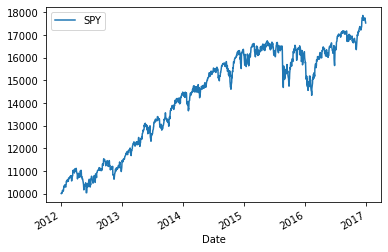

In [59]:
index_port_cumulative = (1 + index_port_returns).cumprod()
index_port_profit = initial_investment_index * index_port_cumulative
index_port_profit.plot()

In [64]:
#Calculating portfolio metrics for randomly selected portfolio, specifically cumulative returns and the value of a $10,000 investment
initial_investment_rand = 10000
weights = [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]

rand_port_returns = rand_port.pct_change().dropna()
rand_port_returns.head()

,DE,GIS,WST,MLM,EXPE,FTI,PAYX,GPN,PRGO,TXT,...,GE,AIG,JCI,CTL,EMR,VMC,SIVB,OKE,HPQ,ABT
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-04,0.014626,0.005955,-0.009436,-0.000396,-0.021241,-0.003821,-0.006572,0.001246,-0.035109,0.019850,...,0.010893,-0.006232,0.003135,-0.006429,0.006496,-0.009577,0.008395,-0.000801,-0.000751,-0.003879
2012-01-05,0.014540,0.004440,0.001059,0.002377,-0.008956,-0.008055,0.017532,-0.004563,0.011147,0.005260,...,-0.000539,-0.000418,0.004583,-0.007549,-0.006454,0.008142,0.047513,0.001030,-0.003759,-0.002301
2012-01-06,0.008084,-0.015963,0.003172,-0.022401,0.016684,-0.002900,0.000975,-0.033965,-0.000936,0.000523,...,0.005391,-0.015475,-0.000207,0.005705,-0.011945,-0.008329,0.000388,-0.002630,-0.003774,-0.009047
2012-01-09,0.005225,-0.001747,0.002108,0.009031,-0.021197,0.007175,0.011042,0.022433,0.005205,-0.002615,...,0.011260,0.019541,0.006223,-0.005132,0.015695,0.005345,0.034102,-0.005160,0.001515,-0.000179
2012-01-10,0.012329,0.008250,0.013673,-0.001202,0.030388,0.013285,-0.000964,0.016456,0.031276,0.057682,...,-0.007423,0.044583,0.008658,0.004073,0.016914,0.005063,0.036537,0.016136,0.009455,0.004655


<AxesSubplot:xlabel='Date'>

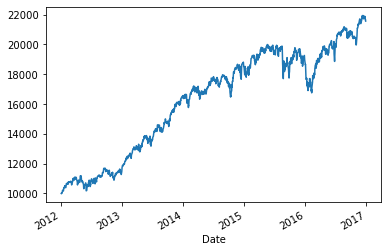

In [65]:
rand_port_combined = rand_port_returns.dot(weights)
rand_port_cumulative = (1 + rand_port_combined).cumprod()
rand_port_profit = initial_investment_rand * rand_port_cumulative
rand_port_profit.plot()

In [67]:
#Plotting using hv plot, the cumulative value of an initial investment of $10K in each of the portfolios over time
low_vol_plot = low_vol_profit.hvplot(label='Low Beta Portfolio')
high_vol_plot = high_vol_profit.hvplot(label='High Beta Portfolio')
rand_port_plot = rand_port_profit.hvplot(label="Randomly Selected Portfolio")
index_plot = index_port_profit.hvplot(label="Index Portfolio (Base Case)")

index_plot + low_vol_plot + high_vol_plot + rand_port_plot

:Layout
   .Curve.Index_Portfolio_left_parenthesis_Base_Case_right_parenthesis :Curve   [Date]   (SPY)
   .Curve.Low_Beta_Portfolio                                           :Curve   [index]   (0)
   .Curve.High_Beta_Portfolio                                          :Curve   [index]   (0)
   .Curve.Randomly_Selected_Portfolio                                  :Curve   [Date]   (0)